### MBD-EN OCT20 - IE School of Human Scienses & Technology

# Data Science Competition

Date: 11/03/2021

#### Loading packages and importing the required libraries:

Here we also define some functions we will use later and will be mentioned when used.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import ipywidgets as ipw
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display="diagram")
#Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge , Lasso
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

def outlier(col, n):
    IQR = col.quantile(.75) - col.quantile(.25)
    upper = col.quantile(.75) + (n*IQR)
    lower = col.quantile(.25) - (n*IQR)
    print("Percent Outliers:", "{:.2%}".format( ( len(train[col > upper]) + len(train[col < lower]) ) / len(train) ) )
    print("Percent Low Outliers:", "{:.2%}".format( len(train[col < lower]) / len(train) ) )
    print("Percent High Outliers:", "{:.2%}".format( len(train[col > upper]) / len(train) ) )
    return lower, upper

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(test_features, test_labels):
    print('Root Mean Squared Error: %.2f'% mean_squared_error(test_features, test_labels,squared = False))
    print('Coefficient of determination: %.2f'%r2_score(test_features, test_labels))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(test_features, test_labels))
    print('MAE: %.2f'% mean_absolute_error(test_features, test_labels))

#### Loading the data into the pandas data frame:

The variable "instant" could be our index since since it is a good key column (identifying each observation with a different value for every row from 1 to 17379).

In [4]:
#train_main = pd.read_csv("hour.csv",index_col="instant",parse_dates = ["dteday"])
train_main = pd.read_csv("train_main.csv", index_col="id")
train_geo = pd.read_csv("train_geo.csv", index_col="id")
train_weather = pd.read_csv("train_weather.csv", index_col="id")
test_main = pd.read_csv("test_main.csv", index_col="id")
test_geo = pd.read_csv("test_geo.csv", index_col="id")
test_weather = pd.read_csv("test_weather.csv", index_col="id")

**Column Legend:**
* **instant:** records index
* **dteday:** date
* **hr:** hour (0 to 23)
* **weathersit:** Weather situation
* **temp:** Normalized temperature in Celsius. The values are divided to 41 (max)
* **atemp:** Normalized feeling temperature in Celsius. The values are divided to 50 (max)
* **hum:** Normalized humidity. The values are divided to 100 (max)
* **windspeed:** Normalized wind speed. The values are divided to 67 (max)
* **casual:** count of casual users
* **registered:** count of registered users
* **cnt:** count of total rental bikes including both casual and registered

### 1.1. Ensuring data quality

We will take a look of the first rows of our data, to see what it looks like by displaying the top 5 rows.

In [64]:
train_1 = train_main.merge(train_geo, how = "left", left_index = True, right_index= True)
train = train_1.merge(train_weather, how = "left", left_index = True, right_index= True)
train["long_dist"] = train["start_Longitude"] - train["end_Longitude"]
train["lat_dist"] = train["start_Latitude"] - train["end_Latitude"]
train['date'] = pd.to_datetime(train['starting_time'])
train["hour"] = train.date.dt.hour
train["month"] = train.date.dt.month
train["day"] = train.date.dt.dayofweek
train["minute"] = train.date.dt.minute
train["hourmin"] = train["hour"]+(train["minute"]/60) 

conditions = [
    (train['day'].isin([1,2,3,4,0])),  # Workdays = weekdays if not holiday
    (train['day'].isin([5,6])) # Weekend or holidays
    ]
values = [0,1]
#create a new column and use np.select to assign values to it using our lists as arguments
train['workday'] = np.select(conditions, values)


train.head(5)

,starting_time,model_van,num_packages,delivery_time,town,start_Longitude,start_Latitude,end_Longitude,end_Latitude,wea_conditions,...,wea_snow,long_dist,lat_dist,date,hour,month,day,minute,hourmin,workday
id,,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,model_A,3,448,Hawkins,-73.950912,40.825974,-73.944740,40.814163,Clear,...,No,-0.006172,0.011810,2016-04-14 20:53:00,20,4,3,53,20.883333,0
2,2016/05/30 23:12:00,model_B,1,784,Hawkins,-73.985680,40.760487,-73.942482,40.786232,Partly_Cloudy,...,No,-0.043198,-0.025745,2016-05-30 23:12:00,23,5,0,12,23.200000,0
3,2016/03/03 11:54:00,model_B,1,844,Hawkins,-73.985420,40.758389,-74.007294,40.726639,Clear,...,No,0.021873,0.031750,2016-03-03 11:54:00,11,3,3,54,11.900000,0
4,2016/05/02 12:34:00,model_A,1,2076,Hawkins,-73.870964,40.773792,-73.989090,40.746052,Overcast,...,No,0.118126,0.027740,2016-05-02 12:34:00,12,5,0,34,12.566667,0
5,2016/03/02 15:53:00,model_A,1,1289,Hawkins,-73.979012,40.745266,-73.979240,40.772480,Rain,...,No,0.000229,-0.027214,2016-03-02 15:53:00,15,3,2,53,15.883333,0


In [4]:
train.to_csv('train.csv')

In [65]:
test_1 = test_main.merge(test_geo, how = "left", left_index = True, right_index= True)
test = test_1.merge(test_weather, how = "left", left_index = True, right_index= True)
test["long_dist"] = test["start_Longitude"] - test["end_Longitude"]
test["lat_dist"] = test["start_Latitude"] - test["end_Latitude"]
test['date'] = pd.to_datetime(test['starting_time'])
test["hour"] = test.date.dt.hour
test["month"] = test.date.dt.month
test["day"] = test.date.dt.dayofweek
test["minute"] = test.date.dt.minute
test["hourmin"] = test["hour"]+(test["minute"]/60) 

conditions = [
    (test['day'].isin([1,2,3,4,0])),  # Workdays = weekdays if not holiday
    (test['day'].isin([5,6])) # Weekend or holidays
    ]
values = [0,1]
#create a new column and use np.select to assign values to it using our lists as arguments
test['workday'] = np.select(conditions, values)

test.head(5)

,starting_time,model_van,num_packages,town,start_Longitude,start_Latitude,end_Longitude,end_Latitude,wea_conditions,wea_temp,...,wea_snow,long_dist,lat_dist,date,hour,month,day,minute,hourmin,workday
id,,,,,,,,,,,,,,,,,,,,,
8495,2016/05/18 23:53:00,model_B,1,Hawkins,-74.001488,40.741226,-73.949318,40.780621,Overcast,12.8,...,No,-0.052170,-0.039394,2016-05-18 23:53:00,23,5,2,53,23.883333,0
8496,2016/02/29 03:54:00,model_B,1,Hawkins,-73.973564,40.749073,-73.972549,40.760288,Clear,10.0,...,No,-0.001015,-0.011215,2016-02-29 03:54:00,3,2,0,54,3.900000,0
8497,2016/04/06 09:52:00,model_B,1,Hawkins,-73.975304,40.790001,-74.014374,40.714127,Haze,23.3,...,No,0.039070,0.075874,2016-04-06 09:52:00,9,4,2,52,9.866667,0
8498,2016/04/12 06:52:00,model_B,2,Hawkins,-74.001671,40.730682,-73.980858,40.760967,Scattered_Clouds,3.9,...,No,-0.020813,-0.030285,2016-04-12 06:52:00,6,4,1,52,6.866667,0
8499,2016/06/11 11:56:00,model_B,1,Hawkins,-73.973259,40.756893,-73.968254,40.767891,Clear,13.9,...,No,-0.005005,-0.010998,2016-06-11 11:56:00,11,6,5,56,11.933333,1


In [6]:
test.to_csv('test.csv')

Looking at the data type of each column and other informations by using info() method which prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.

In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9049 entries, 1 to 8494
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   starting_time      9049 non-null   object        
 1   model_van          9049 non-null   object        
 2   num_packages       9049 non-null   int64         
 3   delivery_time      9049 non-null   int64         
 4   town               9049 non-null   object        
 5   start_Longitude    9049 non-null   float64       
 6   start_Latitude     9049 non-null   float64       
 7   end_Longitude      9049 non-null   float64       
 8   end_Latitude       9049 non-null   float64       
 9   wea_conditions     9049 non-null   object        
 10  wea_temp           9047 non-null   float64       
 11  wea_dptemp         9047 non-null   float64       
 12  wea_humidity       9047 non-null   float64       
 13  wea_windspeed      8392 non-null   float64       
 14  wea_wind

In [8]:
duplicate_rows_train = train[train.duplicated()]
print("number of duplicate rows: ", duplicate_rows_train.shape)

number of duplicate rows:  (555, 25)


In [9]:
all_cols = train.columns.values.tolist()
num_cols = train.select_dtypes(include=np.number).columns.to_list()
cat_cols = train.select_dtypes(exclude = np.number).columns.to_list()

**Numerical Columns Analysis**

Below with the describe() method we have a look at the descriptive statistics of the numerical columns including those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [10]:
print(train.describe())

       num_packages  delivery_time  start_Longitude  start_Latitude  \
count   9049.000000    9049.000000      9049.000000     9049.000000   
mean       1.644933     828.822632       -73.972061       40.749831   
std        1.300979     558.074131         0.043264        0.030838   
min        1.000000      60.000000       -74.017860       40.615288   
25%        1.000000     402.000000       -73.993561       40.737289   
50%        1.000000     677.000000       -73.982178       40.754650   
75%        2.000000    1133.000000       -73.967819       40.769966   
max        6.000000    3300.000000       -73.776619       40.869823   

       end_Longitude  end_Latitude     wea_temp   wea_dptemp  wea_humidity  \
count    9049.000000   9049.000000  9047.000000  9047.000000   9047.000000   
mean      -73.965531     40.756612    11.865790     3.130342     58.762684   
std         0.047724      0.034314     8.547779    10.039775     20.531489   
min       -74.022598     40.610096   -18.300000 

In [11]:
@ipw.interact(Column = ipw.Dropdown(options = num_cols), bin = ipw.IntSlider(value = 10))
def plot_hist(Column, bin):
  sns.distplot(a = train[Column], kde=True, bins = bin)
  return train[Column].value_counts(bins = bin)

interactive(children=(Dropdown(description='Column', options=('num_packages', 'delivery_time', 'start_Longitud…

**Categorical Columns Analysis**

In [12]:
@ipw.interact(Column = ipw.Dropdown(options = cat_cols))
def unique_count(Column):
  value = train[Column].value_counts()
  percent = round(train[Column].value_counts(normalize = True) * 100,2)
  return pd.concat([value, percent], axis = 1, keys=['Counts', 'Percentage (%)'])

interactive(children=(Dropdown(description='Column', options=('starting_time', 'model_van', 'town', 'wea_condi…

### 1.3. Checking possibly redundant variables via correlations

Findind the pairwise correlation of all columns in the dataframe. Any na values are automatically excluded. Any non-numeric data type columns in the dataframe is ignored.

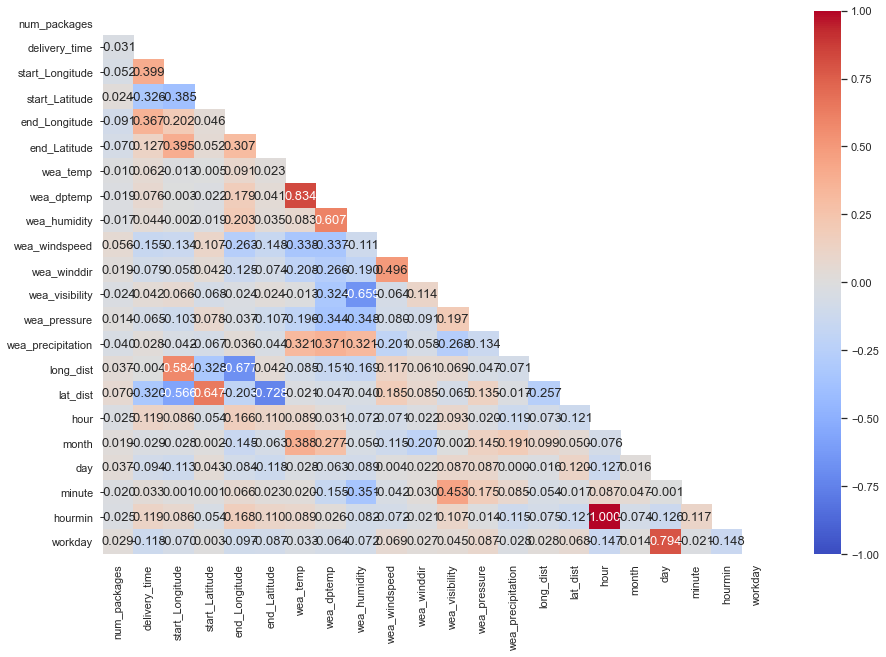

In [66]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.set_style('white')

corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool)) # Generating a mask for the upper triangle
sns.heatmap(corr, cmap='coolwarm',fmt='.3f', annot=True, mask=mask, annot_kws={'size':13}, vmin = -1, vmax = 1)
plt.show()

In [8]:
for col in train.select_dtypes(include=np.number):
    train[col] = train[col].fillna(train[col].median())

In [68]:
train.reset_index(inplace=True)

In [84]:
def train_test_split(data, date_split):

    # training vs target
    x = data[["id", "long_dist", "lat_dist", "end_Longitude", "start_Latitude", "start_Longitude", "end_Latitude", "hour", "day", "hourmin"]]
    y = data[["id", "delivery_time"]]

    # splitting data
    x_train = x[x["id"] < date_split].drop("id", axis=1)
    x_test = x[x["id"] >= date_split].drop("id", axis=1)
    y_train = y[y["id"] < date_split].drop("id", axis=1).values.ravel()
    y_test = y[y["id"] >= date_split].drop("id", axis=1).values.ravel()

    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test

date_split = 6795
x_train, x_test, y_train, y_test = train_test_split(train, date_split)

x_train.info()

x_train: (7349, 9)
x_test: (1700, 9)
y_train: (7349,)
y_test: (1700,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7349 entries, 0 to 7348
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   long_dist        7349 non-null   float64
 1   lat_dist         7349 non-null   float64
 2   end_Longitude    7349 non-null   float64
 3   start_Latitude   7349 non-null   float64
 4   start_Longitude  7349 non-null   float64
 5   end_Latitude     7349 non-null   float64
 6   hour             7349 non-null   int64  
 7   day              7349 non-null   int64  
 8   hourmin          7349 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 574.1 KB


Root Mean Squared Error: 0.00
Coefficient of determination: 1.00
MAPE: 0.00
MAE: 0.00
None
Root Mean Squared Error: 385.97
Coefficient of determination: 0.42
MAPE: 44.70
MAE: 276.42
None


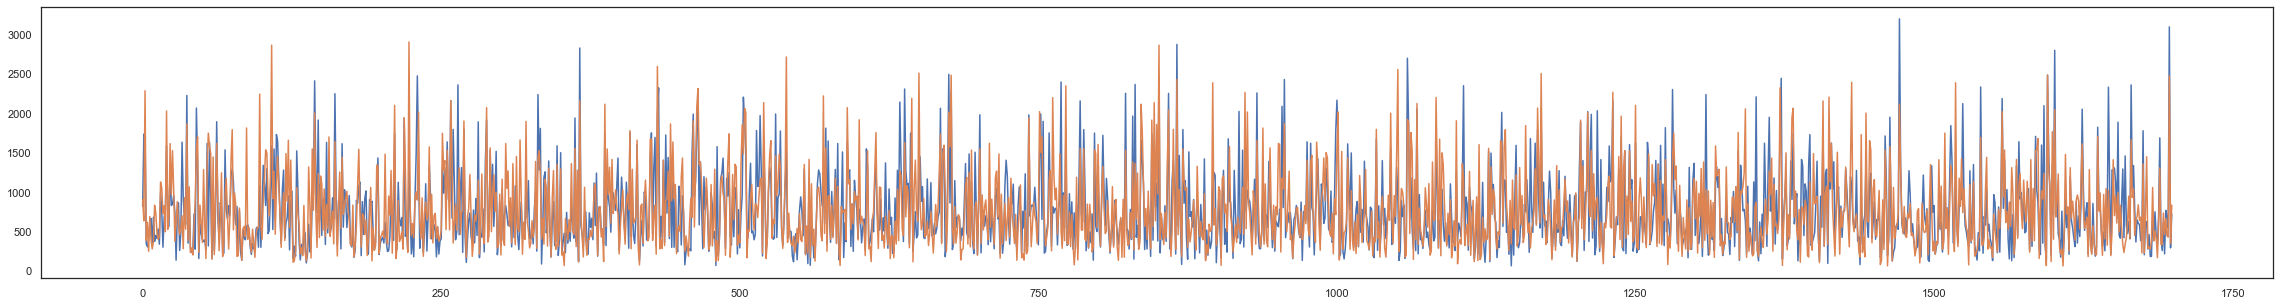

In [85]:
x_train#manual data split & performance evalution
dt = DecisionTreeRegressor(random_state=42)

dt.fit(x_train, y_train)
dt.score(x_test, y_test)

y_hat_train = dt.predict(x_train)
y_hat_test = dt.predict(x_test)

#Measure Test:
print(evaluate(y_train, y_hat_train))
print(evaluate(y_test, y_hat_test))

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

In [86]:
feat_imp = dt.feature_importances_
features = x_train.columns
feat_imp_dt = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_dt

,feature,importance
0,long_dist,0.557174
1,lat_dist,0.217227
2,hourmin,0.051763
3,start_Latitude,0.045985
4,start_Longitude,0.034646
5,end_Latitude,0.029850
6,end_Longitude,0.027873
7,day,0.022563
8,hour,0.012920


max_depth: 1, rmse_train: 387.377, rmse_test=382.555
max_depth: 2, rmse_train: 308.378, rmse_test=339.587
max_depth: 3, rmse_train: 276.973, rmse_test=304.505
max_depth: 4, rmse_train: 250.652, rmse_test=284.389
max_depth: 5, rmse_train: 233.985, rmse_test=271.984
max_depth: 6, rmse_train: 219.144, rmse_test=256.891
max_depth: 7, rmse_train: 205.173, rmse_test=246.183
max_depth: 8, rmse_train: 191.050, rmse_test=245.678
max_depth: 9, rmse_train: 177.307, rmse_test=244.202
max_depth: 10, rmse_train: 162.235, rmse_test=245.230
max_depth: 11, rmse_train: 145.973, rmse_test=248.106
max_depth: 12, rmse_train: 129.546, rmse_test=247.310
max_depth: 13, rmse_train: 112.831, rmse_test=252.613
max_depth: 14, rmse_train: 97.413, rmse_test=254.825
max_depth: 15, rmse_train: 83.407, rmse_test=257.302
max_depth: 16, rmse_train: 70.377, rmse_test=264.724
max_depth: 17, rmse_train: 59.198, rmse_test=261.274
max_depth: 18, rmse_train: 49.411, rmse_test=267.692
max_depth: 19, rmse_train: 40.937, rmse_te

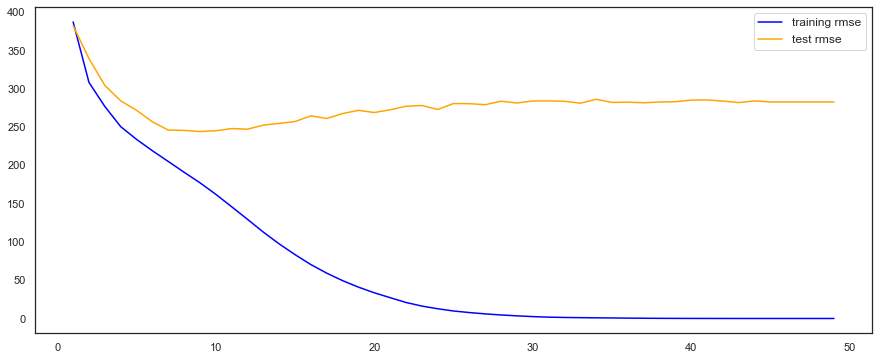

In [19]:
max_depth_range = range(1, 50)

error_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": 42
    }

    # train
    dt_2 = DecisionTreeRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
        
    # evaluate
    rmse_train = mean_absolute_error(y_train, y_hat_train)
    rmse_test = mean_absolute_error(y_test, y_hat_test)
        
    # store results
    error_results.append({
        "max_depth": max_depth, 
        "rmse_train": rmse_train,
        "rmse_test": rmse_test
    })
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, rmse_train: {rmse_train:.3f}, rmse_test={rmse_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["max_depth"], results["rmse_train"], label="training rmse", color="blue")
ax.plot(results["max_depth"], results["rmse_test"], label="test rmse", color="orange")
ax.legend(fontsize=12)

plt.show()

min_samples_leaf: 1, rmse_train: 177.307, rmse_test=244.202
min_samples_leaf: 2, rmse_train: 180.166, rmse_test=242.653
min_samples_leaf: 3, rmse_train: 181.878, rmse_test=241.981
min_samples_leaf: 4, rmse_train: 183.435, rmse_test=242.219
min_samples_leaf: 5, rmse_train: 185.307, rmse_test=240.402
min_samples_leaf: 6, rmse_train: 187.198, rmse_test=239.806
min_samples_leaf: 7, rmse_train: 188.589, rmse_test=239.026
min_samples_leaf: 8, rmse_train: 189.173, rmse_test=237.453
min_samples_leaf: 9, rmse_train: 189.810, rmse_test=237.701
min_samples_leaf: 10, rmse_train: 190.852, rmse_test=238.159
min_samples_leaf: 11, rmse_train: 191.618, rmse_test=238.321
min_samples_leaf: 12, rmse_train: 192.289, rmse_test=238.496
min_samples_leaf: 13, rmse_train: 193.045, rmse_test=237.312
min_samples_leaf: 14, rmse_train: 193.905, rmse_test=236.298
min_samples_leaf: 15, rmse_train: 195.296, rmse_test=236.644
min_samples_leaf: 16, rmse_train: 195.734, rmse_test=238.025
min_samples_leaf: 17, rmse_train:

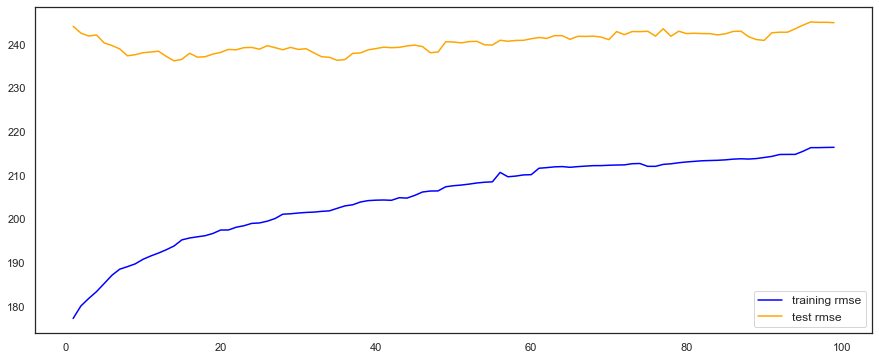

In [20]:
min_samples_range = range(1, 100)
max_depth = 9

error_results = []

# looping through values of max_depth
for min_samples in min_samples_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth,
        "random_state": 42,
        "min_samples_leaf" : min_samples
    }

    # train
    dt_2 = DecisionTreeRegressor(**parameters)
    dt_2.fit(x_train, y_train)
    
    # predict
    y_hat_train = dt_2.predict(x_train)  # prediction on the training set
    y_hat_test = dt_2.predict(x_test)  # prediction on the test set
        
    # evaluate
    rmse_train = mean_absolute_error(y_train, y_hat_train)
    rmse_test = mean_absolute_error(y_test, y_hat_test)
        
    # store results
    error_results.append({
        "min_samples": min_samples, 
        "rmse_train": rmse_train,
        "rmse_test": rmse_test
    })
    
    # print evolution of loop:
    print(f"min_samples_leaf: {min_samples}, rmse_train: {rmse_train:.3f}, rmse_test={rmse_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["min_samples"], results["rmse_train"], label="training rmse", color="blue")
ax.plot(results["min_samples"], results["rmse_test"], label="test rmse", color="orange")
ax.legend(fontsize=12)

plt.show()

Root Mean Squared Error: 328.58
Coefficient of determination: 0.58
MAPE: 42.08
MAE: 236.30
None


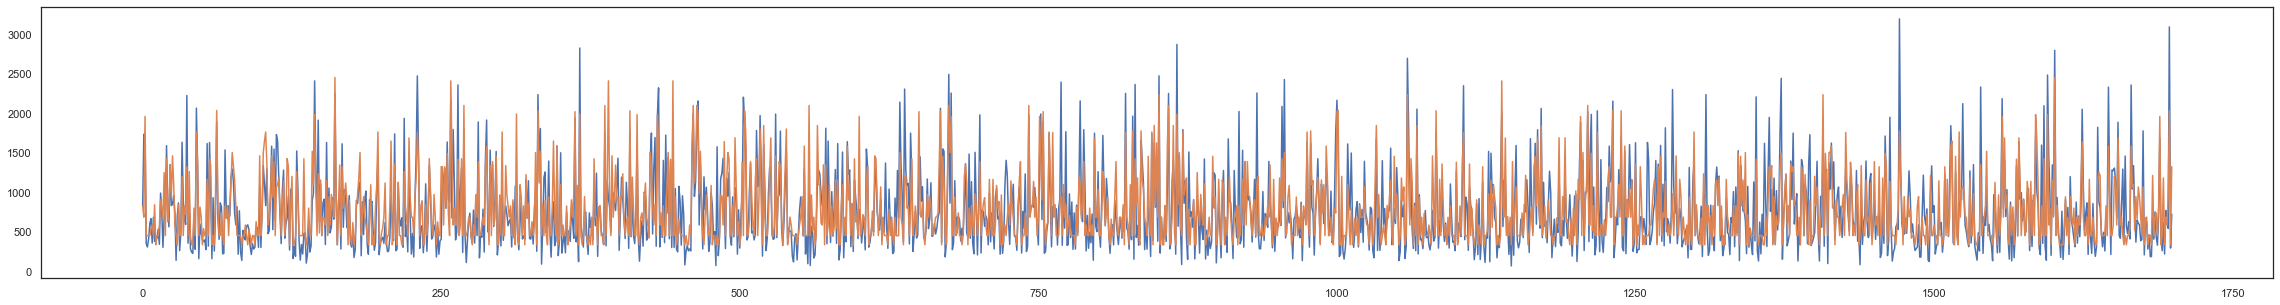

In [21]:
#manual data split & performance evalution
dt = DecisionTreeRegressor(random_state=42, max_depth = 9, min_samples_leaf = 14)

dt.fit(x_train, y_train)
dt.score(x_test, y_test)

y_hat_test = dt.predict(x_test)

#Measure Test:
print(evaluate(y_test, y_hat_test))

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

In [22]:
feat_imp = dt.feature_importances_
features = x_train.columns
feat_imp_dt = pd.DataFrame({
    "feature": features, 
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)
feat_imp_dt

,feature,importance
0,long_dist,0.679537
1,lat_dist,0.243268
2,hour,0.028804
3,start_Latitude,0.027061
4,start_Longitude,0.008432
5,end_Latitude,0.008025
6,end_Longitude,0.004874


In [87]:
best_parameters = ["long_dist", "lat_dist", "end_Longitude", "end_Latitude", "hourmin", "day", "hour"]

x_train_dropped = x_train[best_parameters]
x_test_dropped = x_test[best_parameters]

Root Mean Squared Error: 282.68
Coefficient of determination: 0.69
MAPE: 32.11
MAE: 197.72


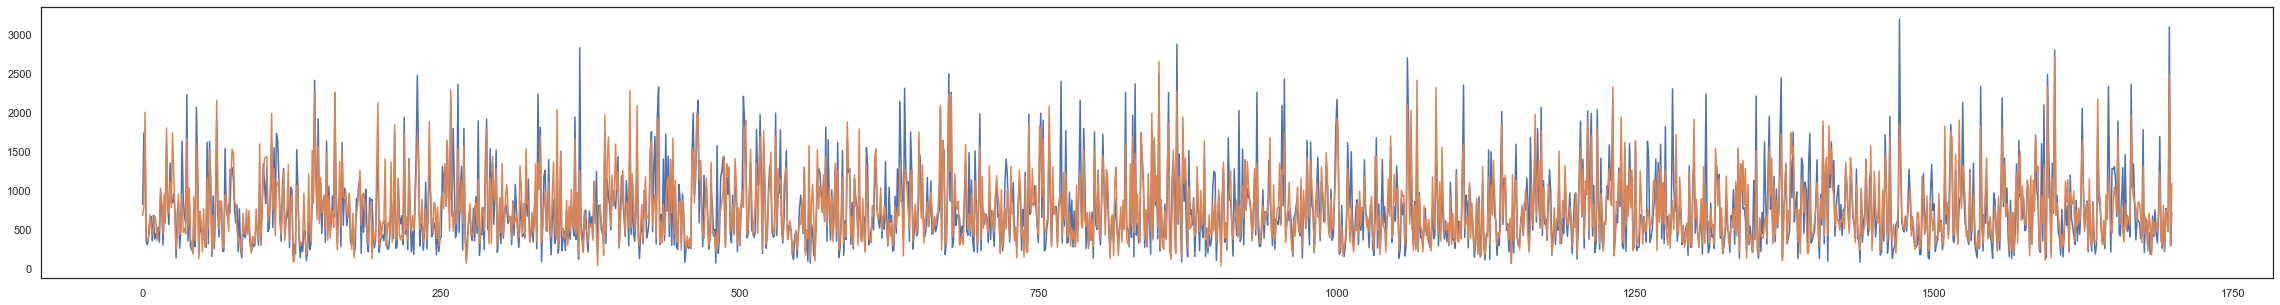

In [88]:
best_xgb_model = XGBRegressor(
                 seed=42, n_jobs =-1
)
best_xgb_model.fit(x_train_dropped,y_train)

y_hat_test = best_xgb_model.predict(x_test_dropped)

#Measure Test:
evaluate(y_test, y_hat_test)

#Plot Test:
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(y_test).plot(ax =ax , label = "train")
pd.Series(y_hat_test).plot(ax =ax , label = "prediction");

In [77]:
xgb_paramter = parameters_for_testing = {
    'learning_rate':[0.3, 0.2, 0.1], # step size shrinkage used to prevent overfitting. Range is [0,1]
    'max_depth':[2,3,4,5,6,7], #determines how deeply each tree is allowed to grow during any boosting round.
    'n_estimators':[60,80,100], #number of trees you want to build
    'subsample':[0.3, 0.5,0.7],  #[0.6,0.8]Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.range: (0,1]
}


gsearch_xgb = GridSearchCV(estimator = XGBRegressor(random_state = 42), param_grid = xgb_paramter, n_jobs= -1 , cv = TimeSeriesSplit().split(x_train_dropped))
gsearch_xgb.fit(x_train_dropped,y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002549F91C9E0>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missi...notone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.2, 0.1],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [60, 80, 100],
                         'subsample': [0.3, 0.5, 0.7]})

In [78]:
print('best params')
print (gsearch_xgb.best_params_)
print('best score')
print (gsearch_xgb.best_score_)

best params
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 80, 'subsample': 0.7}
best score
0.705048398851272


[ 317.13773  845.4241  1209.2338  ...  437.68927  571.22614 1382.0994 ]
Root Mean Squared Error: 218.56
Coefficient of determination: 0.85
MAPE: 26.17
MAE: 148.49


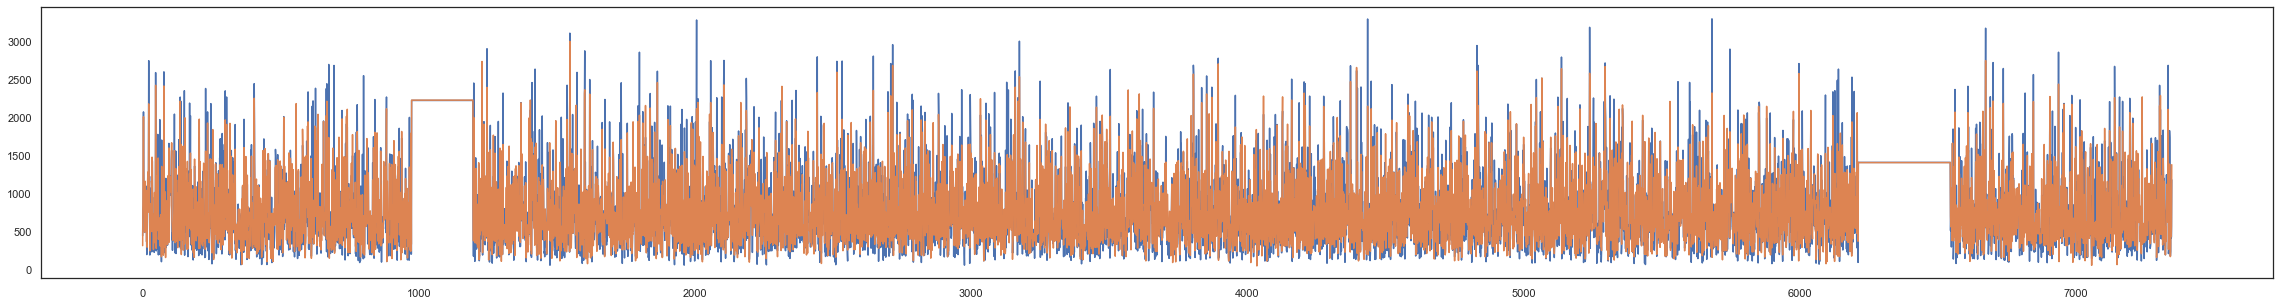

In [89]:
best_parameters = ["long_dist", "lat_dist", "end_Longitude", "end_Latitude", "hourmin", "day"]

final_x_train = x_train[best_parameters]
final_y_train = y_train
final_x_test = test[best_parameters]

model_XGB= XGBRegressor(
                 learning_rate=0.2,
                 max_depth=4,
                 n_estimators= 80,                                                                    
                 subsample=0.7,
                 seed=42, n_jobs =-1
)

model_XGB.fit(final_x_train, final_y_train)
y_hat_xgb = model_XGB.predict(final_x_train)

print(y_hat_xgb)

evaluate(final_y_train , y_hat_xgb)
fig , ax = plt.subplots(figsize =(40,5))
pd.Series(final_y_train).plot(ax =ax , label = "train")
pd.Series(y_hat_xgb).plot(ax =ax , label = "prediction")

In [82]:
pred_prices = best_xgb_model.predict(final_x_test)
print(pred_prices)

[1081.0411   297.91257 1795.7002  ...  980.4097   691.4472   765.39435]


In [81]:
y_hat_xgb_best = best_xgb_model.predict(final_x_train)
print(best_xgb_model.feature_importances_)
evaluate(final_y_train , y_hat_xgb_best)

[0.45474723 0.28618714 0.04520404 0.04770355 0.09110348 0.07505456]
Root Mean Squared Error: 130.01
Coefficient of determination: 0.95
MAPE: 16.99
MAE: 89.26


In [83]:
test["delivery_time"] = pred_prices
my_submission_08 = test[["delivery_time"]]
my_submission_08.to_csv('my_submission_08.csv')